Robust stability
================

In [1]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

We will build a simple non-diagonal system with a diagonal proportional controller

In [2]:
W_I = 0.1
K_c = 1

def G(s):
    return numpy.matrix([[1/(s + 1), 1/(s+2)],
                         [0, 2/(2*s + 1)]])
def K(s):
    return K_c*numpy.asmatrix(numpy.eye(2))

def M(s):
    """ N_11 from eq 8.32 """
    return -W_I*K(s)*G(s)*(numpy.eye(2) + K(s)*G(s)).I

In [3]:
M(2.0)

matrix([[-0.025     , -0.01339286],
        [ 0.        , -0.02857143]])

Let's observe the MV Nyquist diagram of this process

In [4]:
omega = numpy.logspace(-2, 2, 100)
s = 1j*omega

In [5]:
def mvdet(s):
    return numpy.linalg.det(numpy.eye(2) + G(s)*K(s))

fr = numpy.array([mvdet(si) for si in s])

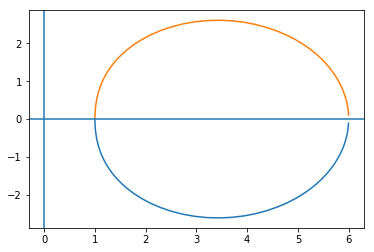

In [6]:
plt.plot(fr.real, fr.imag)
plt.plot(fr.real, -fr.imag)
plt.axhline(0)
plt.axvline(0)

This system looks stable since there are no encirclements of 0.

Now, let's add some uncertainty. We will be building an unstructured $\Delta$ as well as a diagonal $\Delta$.

In [7]:
def maxsigma(m):
    _, S, _ = numpy.linalg.svd(m)
    return S.max()

In [8]:
def unstructuredDelta():
    numbers = numpy.random.rand(4)*2 - 1 + 1j*(numpy.random.rand(4)*2 -1)
    Delta = numpy.asmatrix(numpy.reshape(numbers, (2, 2)))
    return Delta

In [9]:
def diagonalDelta():
    numbers = numpy.random.rand(2)*2 - 1 + 1j*(numpy.random.rand(2)*2 -1)
    Delta = numpy.asmatrix(numpy.diag(numbers))
    return Delta

In [10]:
def allowableDelta(kind):
    while True:
        Delta = kind()
        if maxsigma(Delta) < 1:
            return Delta

So now we can generate an acceptable Delta.

In [11]:
allowableDelta(unstructuredDelta)

matrix([[ 0.52475345-0.41303308j, -0.14919769-0.05964251j],
        [ 0.05016140+0.54802206j, -0.48402212-0.40924132j]])

In [12]:
I = numpy.eye(2)

In [13]:
def Mdelta(Delta, s):
    return M(s)*Delta

In [14]:
kind = diagonalDelta

Let's see what the Nyquist diagrams look like for lots of different allowable Deltas.

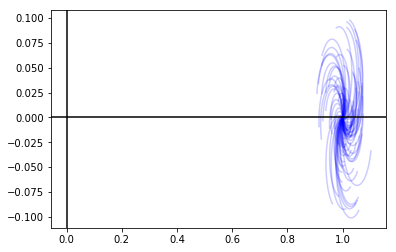

In [15]:
Ndelta = 100

for i in range(Ndelta):
    Delta = allowableDelta(kind)
    fr = numpy.array([numpy.linalg.det(I - Mdelta(Delta, si)) for si in s])
    plt.plot(fr.real, fr.imag, color='blue', alpha=0.2)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.show()

That looks like no $\Delta$ moved us near the zero point, which is where we will become unstable. So this system looks it's robustly stable.

To apply the small gain theorem, we need to check the eigenvalues of $M\Delta$

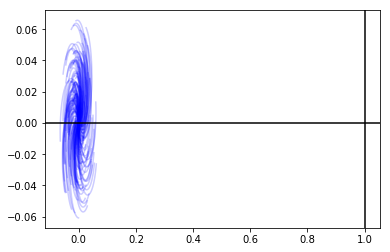

In [16]:
Ndelta = 100

for i in range(Ndelta):
    Delta = allowableDelta(kind)
    fr = numpy.array([numpy.linalg.eigvals(Mdelta(Delta, si)) for si in s])
    plt.plot(fr.real, fr.imag, color='blue', alpha=0.2)
plt.axhline(0, color='black')
plt.axvline(1, color='black')
plt.show()

In [17]:
si = s[0]

How would be find the minimized singular value? One way is via direct optimization.

In [18]:
import scipy.optimize

$$\bar{\sigma}(DM(s)D^{-1})$$

In [19]:
def obj(d):
    d1, d2 = d
    D = numpy.asmatrix([[d1, 0], 
                        [0, d2]])
    return maxsigma(D*M(si)*D.I)

$$\min_D \bar{\sigma}(DM(s)D^{-1})$$

In [20]:
r = scipy.optimize.minimize(obj, [1, 1])

In [21]:
b = []
for si in s:
    r = scipy.optimize.minimize(obj, [4, 4])
    f = r.fun
    b.append(f)

Let's plot all the spectral radii along with some bounds. Remember you can go back and change `kind` to do this for the other kind of ∆.

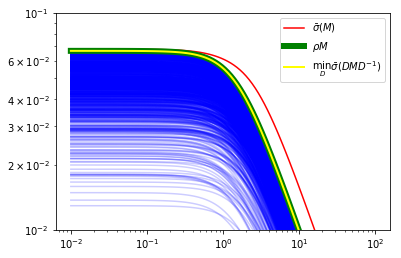

In [22]:
Ndelta = 1000

def specradius(m):
    return numpy.abs(numpy.linalg.eigvals(m)).max()

for i in range(Ndelta):
    Delta = allowableDelta(kind)
    specradiuss = numpy.array([specradius(Mdelta(Delta, si)) for si in s])
    plt.loglog(omega, specradiuss, color='blue', alpha=0.2)   

maxsigmas = numpy.array([maxsigma(M(si)) for si in s])
specradius_of_m = [specradius(M(si)) for si in s]
plt.loglog(omega, maxsigmas, color='red', label=r'$\bar{\sigma}(M)$')
plt.loglog(omega, specradius_of_m, linewidth=6, color='green', label=r'$\rho{M}$')
plt.loglog(omega, b, linewidth=2, color='yellow', label=r'$\min_D \bar{\sigma}(DMD^{-1})$')
plt.axhline(1, color='black')
plt.ylim([1e-2, 1e-1])
plt.legend()
plt.show()